In [1]:
import numpy as np
import matplotlib.pyplot as plt

RNG_SEED = 88888

## 2D Noise Display

In [2]:
def generate_white_noise_2D(n=100, scale=1.0, randomizer=False):
    if randomizer:
        pass
    else:
        np.random.seed(RNG_SEED)
    return np.random.uniform(-scale, scale, size=(n, n))


def generate_gaussian_noise_2D(n=100, mean=0.0, std=1.0, randomizer=False):
    if randomizer:
        pass
    else:
        np.random.seed(RNG_SEED)
    return np.random.normal(loc=mean, scale=std, size=(n, n))


def generate_perlin_noise_2D(n=100, feature_scale=20, randomizer=False):
    def interpolant(t):
        return t * t * t * (t * (t * 6 - 15) + 10)

    def initialize_coordinate():
        x, y = np.meshgrid(np.arange(n), np.arange(n), indexing="ij")
        pixel_coordinate = np.dstack((x, y))
        noise_cell_index = pixel_coordinate // int(n / feature_scale)
        noise_cell_offset = pixel_coordinate / int(n / feature_scale) % 1
        return pixel_coordinate, noise_cell_index, noise_cell_offset

    def initialize_random_gradients(cyclic_boundary=True):
        if randomizer:
            pass
        else:
            np.random.seed(RNG_SEED)
        angles = 2 * np.pi * np.random.rand(feature_scale + 1, feature_scale + 1)
        gradients = np.dstack((np.cos(angles), np.sin(angles)))
        if cyclic_boundary:
            gradients[-1, :] = gradients[0, :]
            gradients[:, -1] = gradients[:, 0]

        tl_gradient = (
            gradients[:-1, :-1]
            .repeat(int(n / feature_scale), 0)
            .repeat(int(n / feature_scale), 1)
        )
        tr_gradient = (
            gradients[1:, :-1]
            .repeat(int(n / feature_scale), 0)
            .repeat(int(n / feature_scale), 1)
        )
        bl_gradient = (
            gradients[:-1, 1:]
            .repeat(int(n / feature_scale), 0)
            .repeat(int(n / feature_scale), 1)
        )
        br_gradient = (
            gradients[1:, 1:]
            .repeat(int(n / feature_scale), 0)
            .repeat(int(n / feature_scale), 1)
        )

        return tl_gradient, tr_gradient, bl_gradient, br_gradient

    def dot_product(
        tl_relative_coordinate, tl_gradient, tr_gradient, bl_gradient, br_gradient
    ):
        directional_vector = np.dstack(
            (tl_relative_coordinate[:, :, 0], tl_relative_coordinate[:, :, 1])
        )
        tl_contribution = np.sum(directional_vector * tl_gradient, 2)
        directional_vector = np.dstack(
            (tl_relative_coordinate[:, :, 0] - 1, tl_relative_coordinate[:, :, 1])
        )
        tr_contribution = np.sum(directional_vector * tr_gradient, 2)
        directional_vector = np.dstack(
            (tl_relative_coordinate[:, :, 0], tl_relative_coordinate[:, :, 1] - 1)
        )
        bl_contribution = np.sum(directional_vector * bl_gradient, 2)
        directional_vector = np.dstack(
            (tl_relative_coordinate[:, :, 0] - 1, tl_relative_coordinate[:, :, 1] - 1)
        )
        br_contribution = np.sum(directional_vector * br_gradient, 2)
        return tl_contribution, tr_contribution, bl_contribution, br_contribution

    def interpolation(
        tl_relative_coordinate,
        tl_contribution,
        tr_contribution,
        bl_contribution,
        br_contribution,
    ):
        weighting = interpolant(
            tl_relative_coordinate,
        )
        temp1 = (
            tl_contribution * (1 - weighting[:, :, 0])
            + tr_contribution * weighting[:, :, 0]
        )
        temp2 = (
            bl_contribution * (1 - weighting[:, :, 0])
            + br_contribution * weighting[:, :, 0]
        )
        temp3 = temp1 * (1 - weighting[:, :, 1]) + temp2 * weighting[:, :, 1]
        return temp3 * np.sqrt(2)

    #
    _, __, tl_relative_coordinate = initialize_coordinate()

    #
    tl_gradient, tr_gradient, bl_gradient, br_gradient = initialize_random_gradients()

    #
    tl_contribution, tr_contribution, bl_contribution, br_contribution = dot_product(
        tl_relative_coordinate, tl_gradient, tr_gradient, bl_gradient, br_gradient
    )

    #
    noise = interpolation(
        tl_relative_coordinate,
        tl_contribution,
        tr_contribution,
        bl_contribution,
        br_contribution,
    )

    #
    noise = (noise - np.min(noise)) / (np.max(noise) - np.min(noise))

    return noise


def generate_fractal_noise_2D(
    n=100,
    feature_scale=1,
    octaves=3,
    persistence=1 / np.exp(1),
    lacunarity=2,
    randomizer=False,
):
    noise = np.zeros((n, n))
    frequency = 1
    amplitude = 1
    for _ in range(octaves):
        noise += amplitude * generate_perlin_noise_2D(
            n, frequency * feature_scale, randomizer
        )
        frequency *= lacunarity
        amplitude *= persistence
    #
    noise = (noise - np.min(noise)) / (np.max(noise) - np.min(noise))
    return noise

In [3]:
white_noise = generate_white_noise_2D(n=256, randomizer=True)
gaussian_noise = generate_gaussian_noise_2D(n=256, randomizer=True)
perlin_noise = generate_perlin_noise_2D(n=256, feature_scale=4, randomizer=False)
fractal_noise = generate_fractal_noise_2D(
    n=256,
    feature_scale=4,
    octaves=3,
    persistence=1 / 1.5,
    lacunarity=4,
    randomizer=False,
)

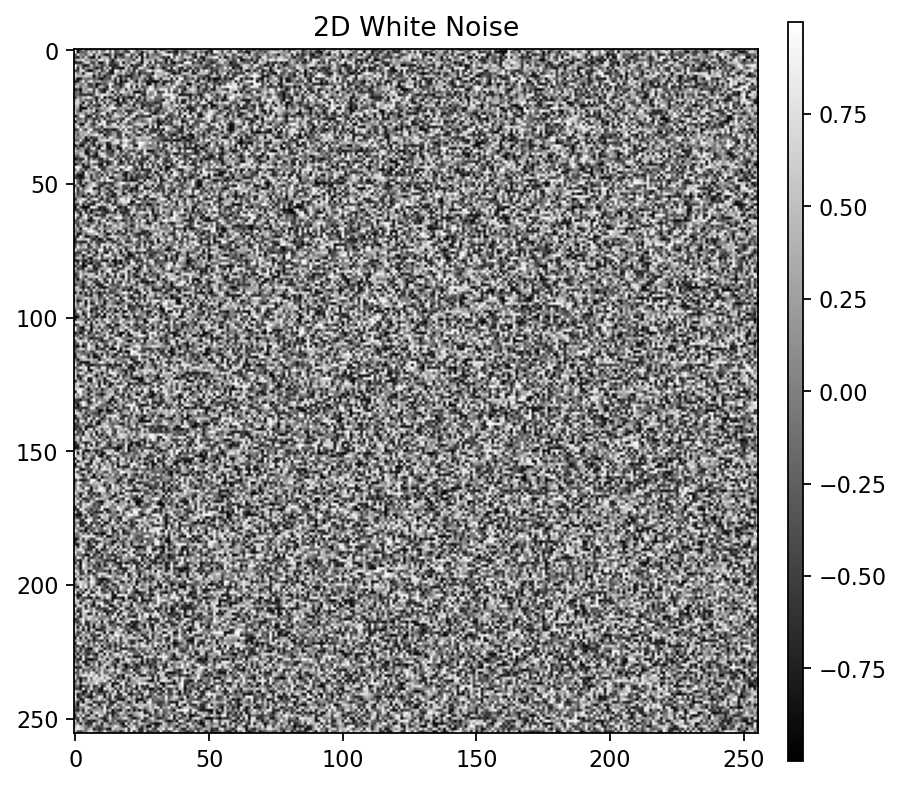

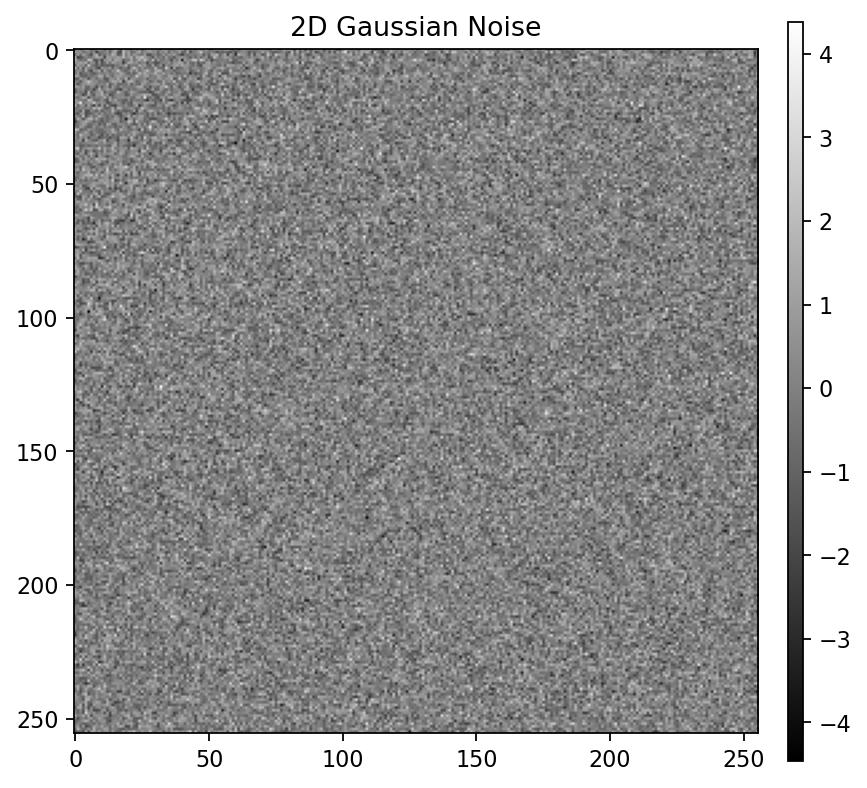

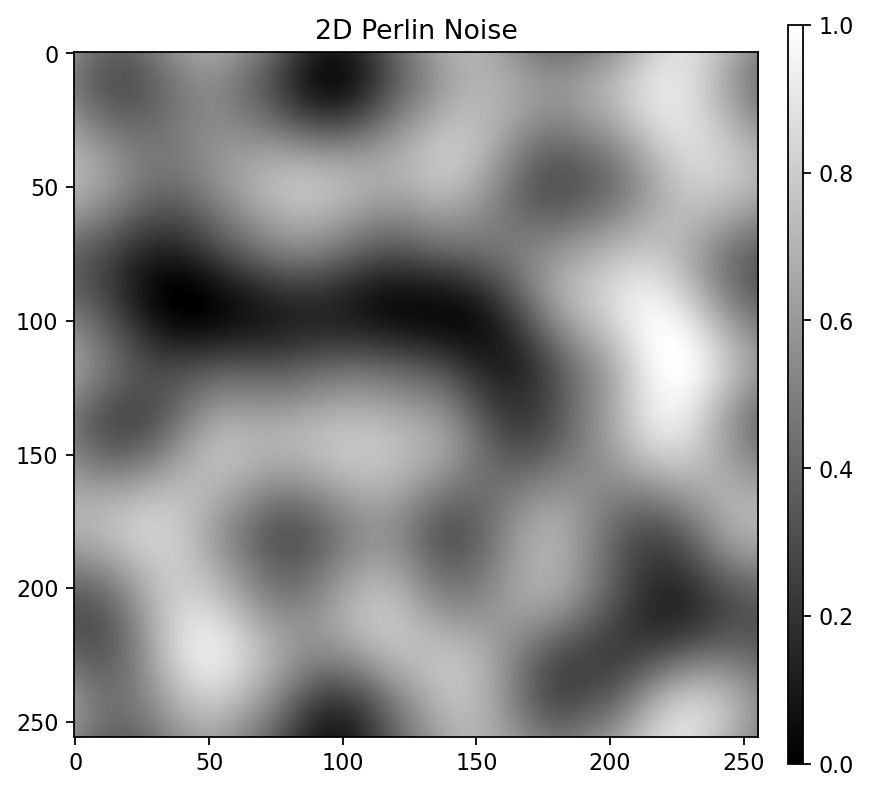

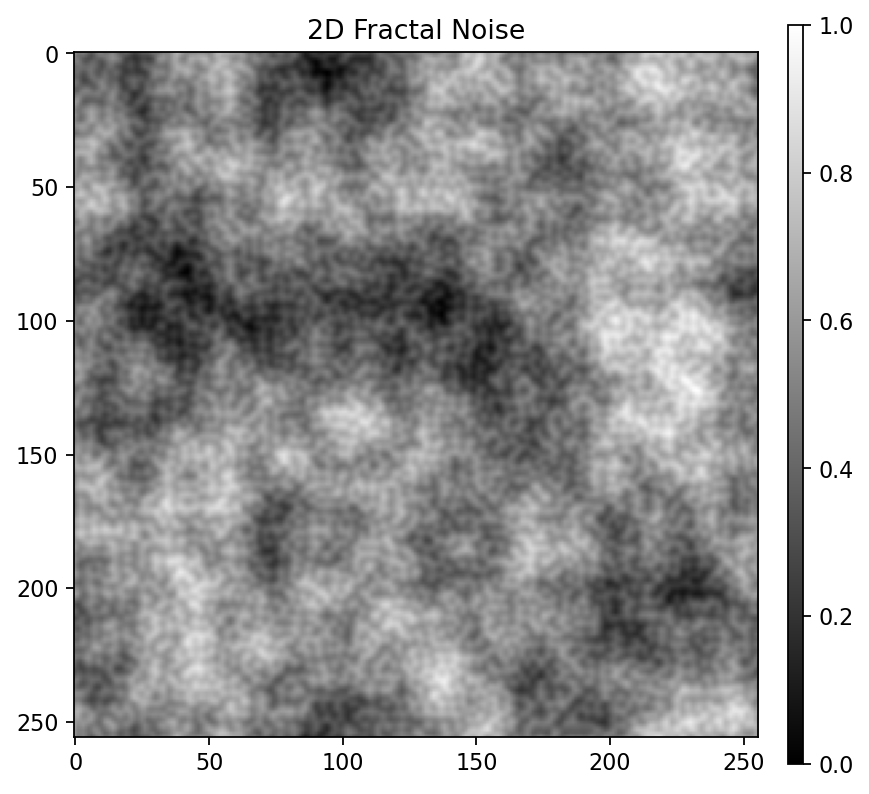

In [4]:
plt.figure(figsize=(6, 6), dpi=160)
plt.title("2D White Noise")
im = plt.imshow(white_noise, cmap="gray")
cbar = plt.colorbar(im, aspect=50, fraction=0.04, pad=0.04)
plt.show()

plt.figure(figsize=(6, 6), dpi=160)
plt.title("2D Gaussian Noise")
im = plt.imshow(gaussian_noise, cmap="gray")
cbar = plt.colorbar(im, aspect=50, fraction=0.04, pad=0.04)
plt.show()

plt.figure(figsize=(6, 6), dpi=160)
plt.title("2D Perlin Noise")
im = plt.imshow(perlin_noise, cmap="gray")
cbar = plt.colorbar(im, aspect=50, fraction=0.04, pad=0.04)
plt.show()

plt.figure(figsize=(6, 6), dpi=160)
plt.title("2D Fractal Noise")
im = plt.imshow(fractal_noise, cmap="gray")
cbar = plt.colorbar(im, aspect=50, fraction=0.04, pad=0.04)
plt.show()